### Imports

In [1]:
import re
import os
import sys
import warnings
import git
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'jupyterlab'

# Import own functions
# Getting the path of the root directory so that we can import repo specific functions
git_repo_object = git.Repo('.', search_parent_directories=True)
git_repo_directory = git_repo_object.working_tree_dir

# Setting path so that we can import functions
sys.path.append(os.path.join(git_repo_directory, "src"))

from elorating import calculation, dataframe # own functions

# Summary

- Experiment
    - Observing competitve behavior between two mice inside a tube. Mice are categorized as winner and loser based on if they pushed the other mouse out of the tube or were pushed.
- Data
    - Excel spreadsheet of recorded tube test results. The relevant columns are those of the "Date" of the recording, the "winner" of the interaction, and the "loser" of the interaction. Each row will be for one interaction between two mice.
    - There is a cage for each sheet of the spreadsheet
    - For each recording session, we will assume that the date will be specified for that first row. We will use this to seperate all the rows into seperate sessions.
- Purpose of this Jupyter Notebook
    - To calculate the Elo rating of each mice after each interaction. The mice start off with an Elo rating of 1000. Elo ratings are calculated with the formula from here: https://www.omnicalculator.com/sports/elo . Then we will plot the change of Elo rating across all interactions. With the number of interactions on the X-Axis and the current Elo rating on the Y. There will be a line for mice.

# Notebook Parameters
Define all parameters and configurations in the following cell to run the entire notebook.

In [2]:
# full path to the excel file that will be taken as input to this notebook
# if only a name of the file is given it will look ofr hte file in the same directory as this script/notebook
raw_data_file_path = r"C:\Users\gcmar\Desktop\GIT_REPOS\social_competiton_elo_rating\jupyter_notebooks\data\pilot_3_tube_test.xlsx"

# names of sheets to process
# if this list is empty all the sheets will be processed
inputted_sheet_names_list = [
    'CAGE1', 
    'CAGE2', 
    'CAGE3', 
    'CAGE4'
]

# name of column to use in all sheets whereupon sessions are divided
# date is the default
session_divider_column = 'date'

# define the row in which the headers are found
# The default is 0
# amke sure that all sheets designated for processing are in this ditionary
header_row_dict = {
    'CAGE1': 0, 
    'CAGE4': 0
}

# define here which individuals have different original cages than the sheets they are found in
# the individual IDs and cage names should be the same as the format followed in the input exel file
id_to_cage = {
    "4.2":"CAGE2",
    "1.1":"CAGE3"
}

# define the strains of each individual
# individual IDs should follow the same format as what was in the input excel file
cage_to_strain = {
    '1.1':"C57",
    '1.2':"C57",
    '1.3':"C57",
    '1.4':"C57",
    '2.1':"C57",
    '2.2':"C57",
    '2.3':"C57",
    '2.4':"C57",
    '3.1':"C57",
    '3.2':"C57",
    '3.3':"C57",
    '3.4':"C57",
    '4.1':"CD1",
    '4.2':"CD1",
    '4.3':"CD1",
    '4.4':"CD1",
    '5.1':"CD1",
    '5.2':"CD1",
    '5.3':"CD1",
    '5.4':"CD1",
    '6.1':"CD1",
    '6.2':"CD1",
    '6.3':"CD1",
    '6.4':"CD1"
}

# Define names of the files and subfolers in the output folder 
subfolder_name = "tube_test_elo_scores_pilot_3" # this defines the subfolder in the output folder where he results will be saved
all_sheet_scores_name = "elo_score_history" # name of the csv that contains all the processed information about all the input sheets
final_elo_score_name = "final_elo_score" # name of the csv file of the final ELO score of each individual
aggregate_all_pairwise_name = "all_pairwise_results_aggregate" # name of the csv that aggregates all pairwise interactions that were performed

# define whether plots should be printed or not
save_plots = True

### *NOTE: No inputs required after this line
# ____________________________________________________________________________

# Process XLSX file
### Define output directory here

In [3]:
# make a directory to store data in
output_dir = os.path.join(".", "output", f"{subfolder_name}")
os.makedirs(output_dir, exist_ok=True)

### Perform calculations on each sheet in XLSX file

In [4]:
# Getting the sheet names for the excel file
xls = pd.ExcelFile(raw_data_file_path)
raw_data_sheet_names = xls.sheet_names
if not inputted_sheet_names_list:
    inputted_sheet_names_list = raw_data_sheet_names
# SELECT sheets from raw_data_sheet_names into inputted_sheet_names_list
# Going through each sheet and creating a dataframe of it from excel object that is already loaded
sheet_df_dict = {}
elo_df_dict = {}
all_earlist_dates = []
all_latest_dates = []
for selected_sheet_name in inputted_sheet_names_list:
    
    # drop rows with no winner or loser values
    try:
        sheet_df_dict[selected_sheet_name] = pd.read_excel(xls, sheet_name=selected_sheet_name, header=header_row_dict[selected_sheet_name]).dropna(subset=['winner', 'loser'])
        sheet_df_dict[selected_sheet_name]["cage"] = selected_sheet_name
    except:
        sheet_df_dict[selected_sheet_name] = pd.read_excel(xls, sheet_name=selected_sheet_name, header=0).dropna(subset=['winner', 'loser'])
        sheet_df_dict[selected_sheet_name]["cage"] = selected_sheet_name
    
    # Getting all the floats from the strings, removing any spaces and other characters
    try:
        sheet_df_dict[selected_sheet_name]['winner'] = sheet_df_dict[selected_sheet_name]['winner'].astype(str).apply(lambda x: re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x)[0] if re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x) else x)
        sheet_df_dict[selected_sheet_name]['loser'] = sheet_df_dict[selected_sheet_name]['loser'].astype(str).apply(lambda x: re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x)[0] if re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x) else x)
    except:
        warnings.warn(f"No 'winner' or 'loser' column(s) detected for {selected_sheet_name} sheet.\n"+
              "Please make sure the sheets in the excel file are in the correct format!")
    
    # fill the empty cells in the date (session) column with values from above if a date column is present
    try:
        sheet_df_dict[selected_sheet_name]['date'] = sheet_df_dict[selected_sheet_name]['date'].fillna(method='ffill')
    except:
        warnings.warn(f"No 'date' column detected for {selected_sheet_name} sheet.\n"+
             "Please make sure the sheets in the excel file are in the correct format!")
    
    # fill the empty cells in the runner column with values from above if a runner column is present
    try:
        sheet_df_dict[selected_sheet_name]['runner'] = sheet_df_dict[selected_sheet_name]['runner'].fillna(method='ffill')
    except:
        warnings.warn(f"No 'runner' column detected for {selected_sheet_name} sheet.\n"+ 
             "Please make sure the sheets in the excel file are in the correct format!")
    
    # fill the empty cells in the ties column with values from above if a ties column is present
    # dropping all rows without 'winner' or 'loser' column values removes ties rows
    try:
        sheet_df_dict[selected_sheet_name]['ties'] = sheet_df_dict[selected_sheet_name]['ties'].fillna(0).astype(bool)            
    except:
        warnings.warn(f"No 'ties' column detected for {selected_sheet_name} sheet.\n"+ 
             "Please make sure the sheets in the excel file are in the correct format!")
    
    # Seeing which rows have a different session than the previous one
    # This will be used to plot vertical lines for each new session       
    sheet_df_dict[selected_sheet_name]["session_number_difference"] = sheet_df_dict[selected_sheet_name][session_divider_column].astype('category').cat.codes.diff()
    sheet_df_dict[selected_sheet_name]["session_number_difference"] = sheet_df_dict[selected_sheet_name]["session_number_difference"].fillna(1)
    
    # add the cage number of the winner and loser (default is the sheet name)
    # map cage updates to mosue ID if mouse has a different original cage
    sheet_df_dict[selected_sheet_name]["winner_cage"] = sheet_df_dict[selected_sheet_name].apply(lambda row: id_to_cage.get(row["winner"], selected_sheet_name), axis=1)
    sheet_df_dict[selected_sheet_name]["loser_cage"] = sheet_df_dict[selected_sheet_name].apply(lambda row: id_to_cage.get(row["loser"], selected_sheet_name), axis=1)
    
    # Calculate the ELO score
    try:    
        elo_dict = calculation.iterate_elo_rating_calculation_for_dataframe(dataframe=sheet_df_dict[selected_sheet_name],
                                                                            winner_id_column='winner', 
                                                                            loser_id_column='loser',
                                                                            additional_columns=sheet_df_dict[selected_sheet_name].columns.tolist(), 
                                                                            tie_column='ties')
    except:
        elo_dict = calculation.iterate_elo_rating_calculation_for_dataframe(dataframe=sheet_df_dict[selected_sheet_name],
                                                                            winner_id_column='winner', 
                                                                            loser_id_column='loser',
                                                                            additional_columns=sheet_df_dict[selected_sheet_name].columns.tolist(),
                                                                            tie_column=None)
    # convert output of function dicionary to pandas dataframe 
    elo_df_dict[selected_sheet_name] = pd.DataFrame(elo_dict).T
    
    # add subject and agent cage IDs
    elo_df_dict[selected_sheet_name]["subject_cage"] = elo_df_dict[selected_sheet_name]["cage"]
    elo_df_dict[selected_sheet_name]["agent_cage"] = elo_df_dict[selected_sheet_name]["cage"]
    elo_df_dict[selected_sheet_name]["subject_cage"] = elo_df_dict[selected_sheet_name].apply(lambda row: id_to_cage.get(row["subject_id"], selected_sheet_name), axis=1)
    elo_df_dict[selected_sheet_name]["agent_cage"] = elo_df_dict[selected_sheet_name].apply(lambda row: id_to_cage.get(row["agent_id"], selected_sheet_name), axis=1)
    
    # get earliest and latest dates
    all_earlist_dates.append(elo_df_dict[selected_sheet_name][session_divider_column].min())
    all_latest_dates.append(elo_df_dict[selected_sheet_name][session_divider_column].max())

C:\Users\gcmar\AppData\Local\Temp\ipykernel_22300\147017821.py:49: UserWarning:

No 'ties' column detected for CAGE1 sheet.
Please make sure the sheets in the excel file are in the correct format!

C:\Users\gcmar\AppData\Local\Temp\ipykernel_22300\147017821.py:49: UserWarning:

No 'ties' column detected for CAGE2 sheet.
Please make sure the sheets in the excel file are in the correct format!

C:\Users\gcmar\AppData\Local\Temp\ipykernel_22300\147017821.py:49: UserWarning:

No 'ties' column detected for CAGE3 sheet.
Please make sure the sheets in the excel file are in the correct format!

C:\Users\gcmar\AppData\Local\Temp\ipykernel_22300\147017821.py:49: UserWarning:

No 'ties' column detected for CAGE4 sheet.
Please make sure the sheets in the excel file are in the correct format!



### Combine all processed sheets into a single file for further processing
The output csv that contains all the processed sheets in one file is generated here alongside the csv containing the final ELO score of each individual 

In [5]:
# Combining all the dataframes into one
all_sheet_elo_score_df = pd.concat(list(elo_df_dict.values()))

# get all unique IDs
all_subject_ids = set(all_sheet_elo_score_df["subject_id"].unique()).union(set(all_sheet_elo_score_df["agent_id"].unique()))

# add strain data (default is the id)
if cage_to_strain:
    all_sheet_elo_score_df["subject_strain"] = all_sheet_elo_score_df["subject_id"]
    all_sheet_elo_score_df["agent_strain"] = all_sheet_elo_score_df["agent_id"]
    all_sheet_elo_score_df["subject_strain"] = all_sheet_elo_score_df['subject_id'].replace(cage_to_strain)
    all_sheet_elo_score_df["agent_strain"] = all_sheet_elo_score_df['agent_id'].replace(cage_to_strain)

# get final elo score for each subject
final_subject_elo_score_df = all_sheet_elo_score_df.drop_duplicates(subset='subject_id', keep='last')

# get rank for each elo score
final_subject_elo_score_df = final_subject_elo_score_df.copy()
final_subject_elo_score_df["rank"] = final_subject_elo_score_df.groupby("subject_cage")["updated_elo_rating"].rank("dense", ascending=False)
final_subject_elo_score_df = final_subject_elo_score_df[["subject_id","subject_cage","updated_elo_rating","rank"]].reset_index(drop=True)

# Turning the Dates into a easier to read format
# Getting the 0th part of split to remove seconds
try:
    earliest_date = str(min(all_earlist_dates)).split()[0]
    latest_date = str(max(all_latest_dates)).split()[0]
except:
    earliest_date = None
    latest_date = None
    
# get cages list
all_cages_list = inputted_sheet_names_list

In [6]:
all_sheet_elo_score_df

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,runner,...,loser,notes,cage,session_number_difference,winner_cage,loser_cage,subject_cage,agent_cage,subject_strain,agent_strain
0,1,1.1,1.2,1000,1010.0,1,1,2,0,Jocelyn,...,1.2,NaN,CAGE1,1.0,CAGE3,CAGE1,CAGE3,CAGE1,C57,C57
1,1,1.2,1.1,1000,990.0,0,2,1,1,Jocelyn,...,1.2,NaN,CAGE1,1.0,CAGE3,CAGE1,CAGE1,CAGE3,C57,C57
2,2,1.2,1.3,990.0,1000.3,1,2,3,0,Jocelyn,...,1.3,NaN,CAGE1,0.0,CAGE1,CAGE1,CAGE1,CAGE1,C57,C57
3,2,1.3,1.2,1000,989.7,0,3,2,1,Jocelyn,...,1.3,NaN,CAGE1,0.0,CAGE1,CAGE1,CAGE1,CAGE1,C57,C57
4,3,1.4,1.3,1000,1009.7,1,2,4,0,Jocelyn,...,1.3,NaN,CAGE1,0.0,CAGE1,CAGE1,CAGE1,CAGE1,C57,C57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,46,4.4,4.1,844.6,838.2,0,4,3,1,Jocelyn,...,4.4,NaN,CAGE4,0.0,CAGE4,CAGE4,CAGE4,CAGE4,CD1,CD1
92,47,4.2,4.4,1152.6,1155.4,1,1,4,0,Jocelyn,...,4.4,NaN,CAGE4,0.0,CAGE2,CAGE4,CAGE2,CAGE4,CD1,CD1
93,47,4.4,4.2,838.2,835.4,0,4,1,1,Jocelyn,...,4.4,NaN,CAGE4,0.0,CAGE2,CAGE4,CAGE4,CAGE2,CD1,CD1
94,48,4.3,4.1,1025.9,1034.7,1,2,3,0,Jocelyn,...,4.1,NaN,CAGE4,0.0,CAGE4,CAGE4,CAGE4,CAGE4,CD1,CD1


In [7]:
final_subject_elo_score_df

,subject_id,subject_cage,updated_elo_rating,rank
0,1.2,CAGE1,1054.5,1.0
1,1.4,CAGE1,897.9,2.0
2,1.1,CAGE3,1165.3,1.0
3,1.3,CAGE1,882.3,3.0
4,2.2,CAGE2,965.6,4.0
5,2.4,CAGE2,833.7,5.0
6,2.3,CAGE2,1072.9,3.0
7,2.1,CAGE2,1127.8,2.0
8,3.4,CAGE3,1147.4,2.0
9,3.2,CAGE3,1024.4,3.0


### Calculate aggregate dominance of individuals for the pairwise comparitive tests done
The csv containing all pairwise aggregate comparisons is generated here.

In [8]:
# get all the possible pairwise groups
grouped_df = pd.DataFrame(all_sheet_elo_score_df.groupby(["subject_id", "agent_id", 'loser', 'winner']).size()).reset_index()
# get the loser counts and list of loser IDs
df_loser = grouped_df.groupby(["subject_id", "agent_id"]).agg({0: 'min', 'loser': lambda x: x.unique()}).reset_index()
df_loser = df_loser.rename(columns={0: 'loser_count'})
# get only the top loser from loser list
df_loser['loser'] = df_loser['loser'].apply(lambda x: x[0])
# get the winner counts and list of winner IDs
df_winner= grouped_df.groupby(["subject_id", "agent_id"]).agg({0: 'max', 'winner': lambda x: x.unique()}).reset_index()
df_winner = df_winner.rename(columns={0: 'winner_count'})
# get only the top winner from winner list
df_winner['winner'] = df_winner['winner'].apply(lambda x: x[0])
# merge the winner and loser dataframes
df_winner_loser = pd.merge(df_loser, df_winner)
# get the total number of experiments and merge this vlaue with winner loser datframe
df_total = all_sheet_elo_score_df.groupby(["subject_id", "agent_id"]).size().reset_index()
df_total = df_total.rename(columns={0: 'total_count'})
df_pairwise_all = pd.merge(df_winner_loser, df_total)
# turn losing ount to 0 if it is the same as the total count
df_pairwise_all.loc[df_pairwise_all['loser_count'] == df_pairwise_all['total_count'], 'loser_count'] = 0
# add a draw column when losing count equals winning count
df_pairwise_all["draw"] = False
df_pairwise_all.loc[df_pairwise_all['loser_count'] == df_pairwise_all['winner_count'], 'draw'] = True
# remove duplicates in experiments
df_pairwise_all = df_pairwise_all.drop_duplicates(df_pairwise_all.columns.difference(['subject_id', 'agent_id'])).reset_index(drop=True)

In [9]:
df_pairwise_all

,subject_id,agent_id,loser_count,loser,winner_count,winner,total_count,draw
0,1.1,1.2,0,1.2,8,1.1,8,False
1,1.1,1.3,0,1.3,8,1.1,8,False
2,1.1,1.4,0,1.4,8,1.1,8,False
3,1.2,1.3,0,1.3,8,1.2,8,False
4,1.2,1.4,0,1.4,8,1.2,8,False
5,1.3,1.4,3,1.3,5,1.4,8,False
6,2.1,2.2,1,2.1,7,2.2,8,False
7,2.1,2.3,1,2.1,7,2.3,8,False
8,2.1,2.4,0,2.4,8,2.1,8,False
9,2.2,2.3,0,2.2,8,2.3,8,False


# Save created tables to CSV files

In [10]:
# Save CSVs
all_sheet_elo_score_df.to_csv(os.path.join(output_dir, f"{all_sheet_scores_name}.csv"))
final_subject_elo_score_df.to_csv(os.path.join(output_dir, f"{final_elo_score_name}.csv"))
df_pairwise_all.to_csv(os.path.join(output_dir, f"{aggregate_all_pairwise_name}.csv"))

# Visualization
### ELO plots for each sheet

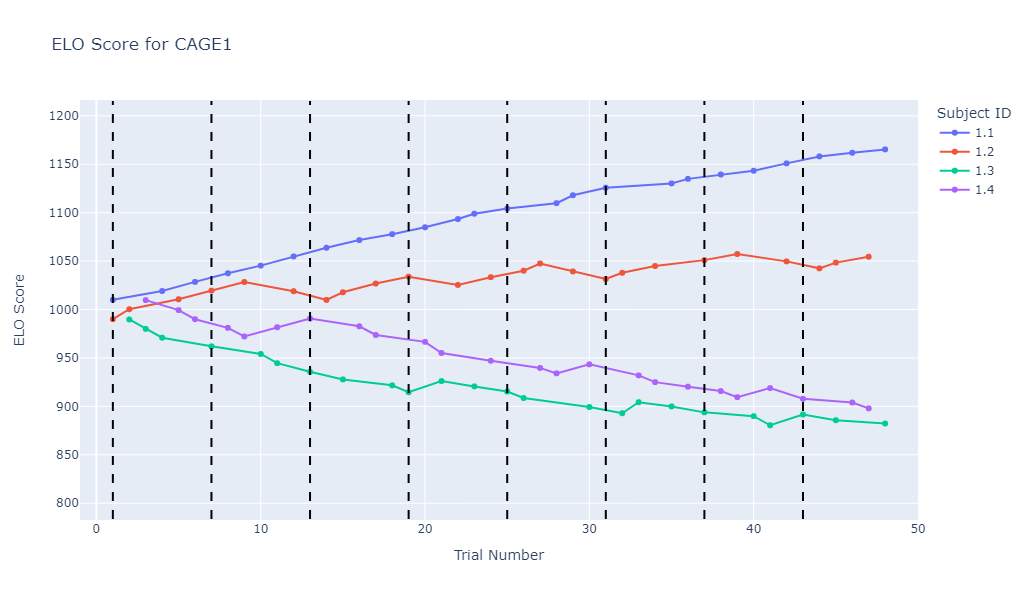

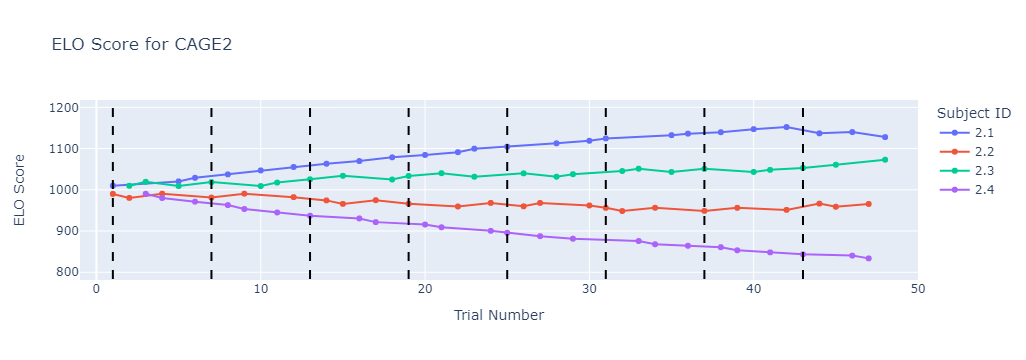

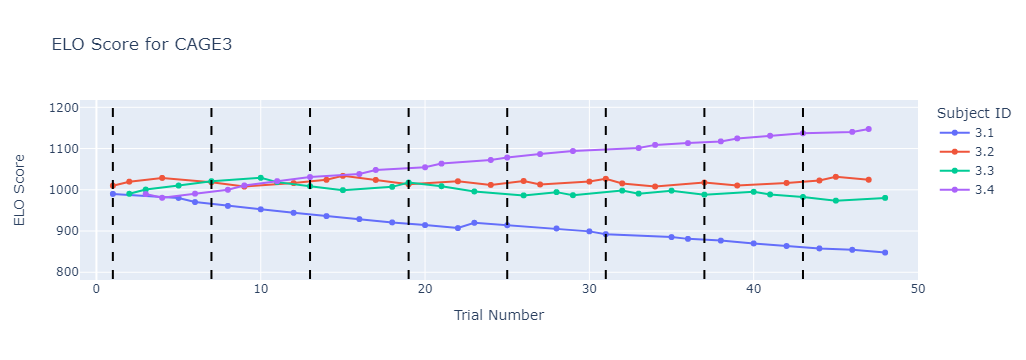

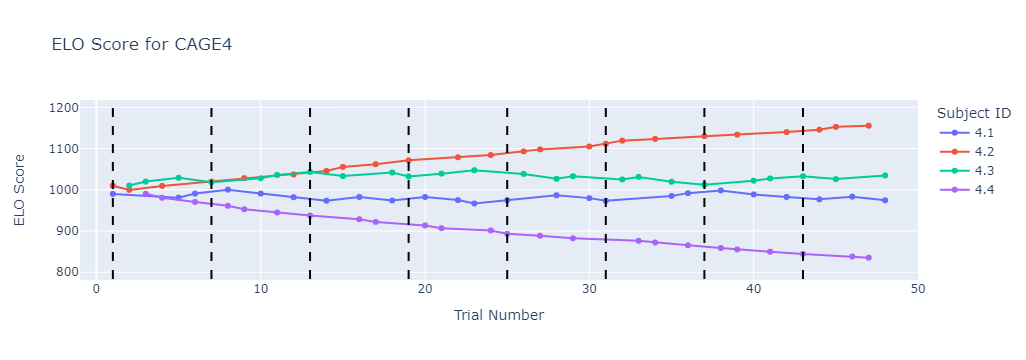

In [11]:
# change the config for exporting hte png iamge fro mthe plot at a higher resolution
config = {
    'toImageButtonOptions': {
        'format': 'png',
        'filename': 'custom_image',
        'height': 600,
        'width': 800,
        'scale': 10
    }
}

# Getting the highest and lowest Elo rating for cutoffs of the Y-axis
max_elo_rating = all_sheet_elo_score_df["updated_elo_rating"].max()
min_elo_rating = all_sheet_elo_score_df["updated_elo_rating"].min()
max_match_num = all_sheet_elo_score_df["total_match_number"].max()
min_match_num = all_sheet_elo_score_df["total_match_number"].min()

for key, value in elo_df_dict.items():
    # Drawing vertical lines that represent when each session begins
    # Based on when a row has a different session than the previous row
    session_arr = value[value['session_number_difference'] == 1.0]['total_match_number'].unique()
    vertical_lines_lst = []
    for session_int in session_arr:
        shape = {'type': 'line', 
                 'x0': session_int, 
                 'y0': min_elo_rating-50, 
                 'x1': session_int, 
                 'y1': max_elo_rating+50,
                 'line': {
                    'color': 'black',
                    'width': 2,
                    'dash': 'dash'
                }}
        vertical_lines_lst.append(shape)
        
    # Drawing a line for each subject
    subject_id_arr = value['subject_id'].unique()
    subject_id_arr.sort()
    subject_lines_lst = []
    for subject in subject_id_arr:
        subject_df = value[value['subject_id'] == subject]
        trace = go.Scatter(x=subject_df["total_match_number"], 
                           y=subject_df["updated_elo_rating"], 
                           mode='lines+markers', 
                           name=subject)
        subject_lines_lst.append(trace)

    # Create a layout with the shapes
    layout = go.Layout(shapes=vertical_lines_lst)

    # Create a Figure object with the traces and layout
    fig = go.Figure(data=subject_lines_lst, layout=layout)
    fig.update_xaxes(range=[min_match_num-2, max_match_num+2])
    fig.update_layout(legend_title_text='Subject ID',
                     title_text=f'ELO Score for {key}',
                     xaxis_title='Trial Number',
                     yaxis_title='ELO Score',
                     # width=1000,
                     height=600)
    
    
    
    # Show the figure
    fig.show(config=config)
    
    # save figures to disk
    # if kaleido is not installed only html is exported (a png can be saved from the html file)
    if save_plots:
        try:
            fig.write_image(output_dir+"/"+f'ELO Score for {key}'+'.png', scale=5)
            fig.write_image(output_dir+"/"+f'ELO Score for {key}'+'.svg')
            fig.write_html(output_dir+"/"+f'ELO Score for {key}'+'.html', config=config)
        except:
            fig.write_html(output_dir+"/"+f'ELO Score for {key}'+'.html', config=config)